## Setup File

Import function

In [61]:
import os
import shutil
import zipfile
import pickle
import re
import csv
import pandas as pd
import numpy as np
from scipy.signal import butter, lfilter, freqz

import matplotlib.pyplot as plt
%matplotlib inline

Create Folders if not existing

In [19]:
#File names for the angel and power data
a_data = 'Collected Data/' + 'axis_data_100_percent.txt' #The angle data 
p_data = 'Collected Data/' + '12_11_100_percent_dat.csv' #The power data

#Path to the different folders
data_path = 'data'
temp_path = data_path + '/temp'
backup_path = data_path + '/backup'

if not os.path.isdir(data_path):
    os.mkdir(data_path)
    os.mkdir(temp_path)
    os.mkdir(backup_path)

## Preprocessing

Preprocess Robotic arms trejectory

In [20]:
with open(a_data, 'r') as file:
    try:
        data = file.read()
        file.close()
    except UnicodeDecodeError:
        file.close()
data = data.splitlines()
data = data[4:len(data)-6] #Text information on first four rows and weird data last six rows

time_steps = len(data)
data_dim = len(data[0].split()[1:])

traj_data = np.ndarray((time_steps,data_dim))
print(np.shape(traj_data))
i = 0
for row in data:
    traj_data[i] = np.array([float(n) for n in row.split()[1:]])
    i += 1


(13899, 6)


Preprocess Voltage/current Measurements

In [21]:
f = open(p_data)

data = []
for line in f:
    data_line = line.rstrip().split('\t')
    data.append(data_line)

Volt_Amp_data = []
for file in data[9:]:
    file = file[0].replace(',','.')
    file = file.replace(' ','')
    Volt_Amp_data = Volt_Amp_data + [[float(n) for n in file.split(';')[:len(file.split(';'))]]]

Preprocessing "Calculate Power form Voltage/current measurements

In [22]:
power_data = []
power_time = []
amp_data = []
voltage_data = []
#TODO: If statement that handles if we measure 1 or 3 phase
for sample in Volt_Amp_data:
    power = np.abs(sample[1]*sample[2]) \
#          + np.abs(sample[2]*sample[5]) \
#          + np.abs(sample[3]*sample[6])
    power_data.append(power)
    amp_data.append(sample[2])
    voltage_data.append(sample[1])
    power_time.append(sample[0])

Figure ploting (testing)

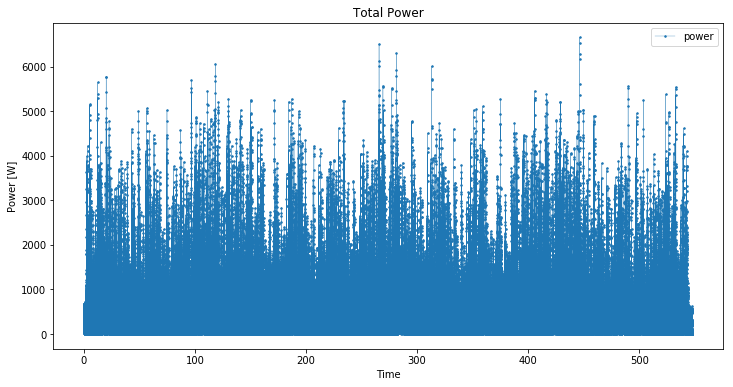

In [126]:
plt.figure(figsize=(12,6))
fig = plt.subplot()
x = range(len(power_data))
fig.plot(power_time, power_data,  label='power',  marker='o',linewidth=0.3, markersize=1.5)
fig.legend();
fig.set_ylabel('Power [W]')
fig.set_xlabel('Time')
fig.set_title('Total Power');

### Downsample and find start of power measurements

In [23]:
power_data_downsampled = power_data[0:len(power_data):3]
amp_data_downsampled = amp_data[0:len(amp_data):3]
power_time_downsampled = sg.decimate(power_time, 3)
voltage_data_downsampled = sg.decimate(voltage_data, 3)

Start at sample: 134  corresponding to time: 1.5895933762091137 sec


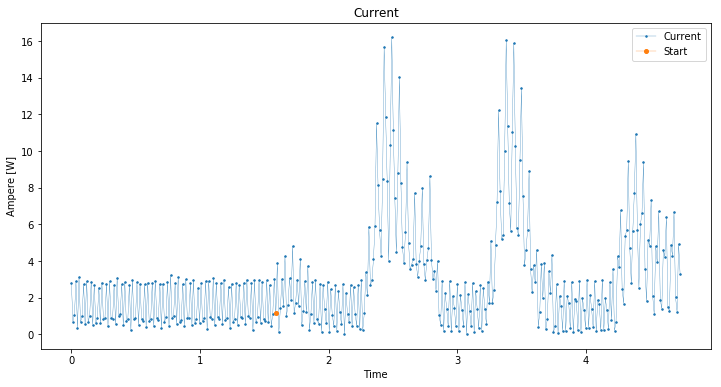

In [24]:
Start_current_indicator = 3.8
for i in range(len(amp_data)):
    if np.abs(amp_data_downsampled[i])>Start_current_indicator:
        break
print('Start at sample:',i-1,' corresponding to time:',power_time_downsampled[i-1],'sec')


plt.figure(figsize=(12,6))
fig = plt.subplot()
x = range(len(power_data))
fig.plot(power_time_downsampled[0:400], np.abs(amp_data_downsampled[0:400]),  label='Current',  marker='o',linewidth=0.3, markersize=1.5)
fig.plot(power_time_downsampled[i-1], np.abs(amp_data_downsampled[i-1]),  label='Start',  marker='o',linewidth=0.3, markersize=4)
fig.legend();
fig.set_ylabel('Ampere [W]')
fig.set_xlabel('Time')
fig.set_title('Current');

In [25]:
#Cut off power measurements at end of angle data measurements
power_data_synced = power_data_downsampled[i-1:i-1+len(traj_data)]
power_data_synced = np.array(power_data_synced)

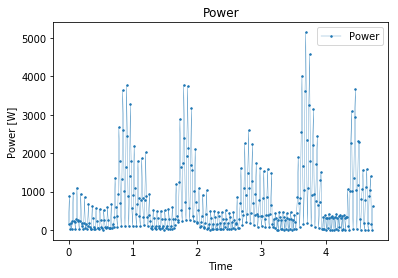

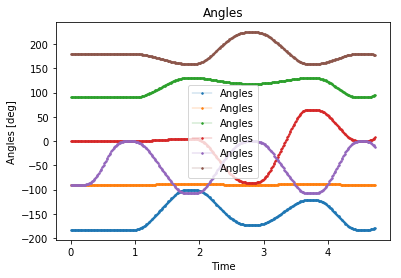

In [59]:
fig1, ax1 = plt.subplots()
ax1.plot(power_time_downsampled[0:400], power_data_synced[0:400],  label='Power',  marker='o',linewidth=0.3, markersize=1.5)
ax1.legend();
ax1.set_ylabel('Power [W]')
ax1.set_xlabel('Time')
ax1.set_title('Power');

fig2, ax2 = plt.subplots()
ax2.plot(power_time_downsampled[0:400], traj_data[0:400],  label='Angles',  marker='o',linewidth=0.3, markersize=1.5)
ax2.legend();
ax2.set_ylabel('Angles [deg]')
ax2.set_xlabel('Time')
ax2.set_title('Angles');

Save the data

In [26]:
with open(data_path + '/joint_angle_data.pickle', 'wb') as file:
    pickle.dump(traj_data, file)
    file.close()
with open(data_path + '/power_data.pickle', 'wb') as file:
    pickle.dump(power_data_synced, file)
    file.close()

## Augment inputs with velocity, acceleration and pseudopower

In [27]:
data_path = 'data'
temp_path = data_path + '/temp'
backup_path = data_path + '/backup'

with open(data_path + '/joint_angle_data.pickle', 'rb') as file:
    joint_angle_data = pickle.load(file)
    file.close()

In [59]:
#Velocity 
delta_t = 0.012
vel = np.ndarray(np.shape(joint_angle_data))
for i in range(len(joint_angle_data)-1):
    vel[i] = np.divide( joint_angle_data[i+1] - joint_angle_data[i], delta_t)
vel[-1] = vel[-2]

#Acceleration
acc = np.ndarray(np.shape(joint_angle_data))
for i in range(len(joint_angle_data)-1):
    acc[i] = np.divide( vel[i+1] - vel[i], delta_t)
acc[-1] = acc[-2]

#Pseudopower
psi = np.ndarray((np.shape(joint_angle_data)[0],1))
for i in range(len(joint_angle_data)):
    psi[i] = np.sum(np.abs(vel[i]*acc[i]))


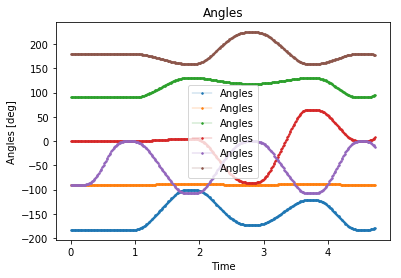

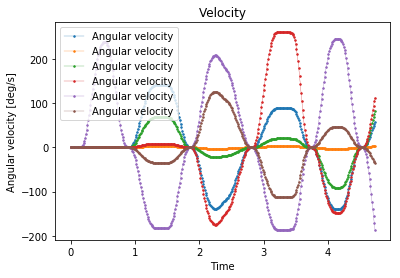

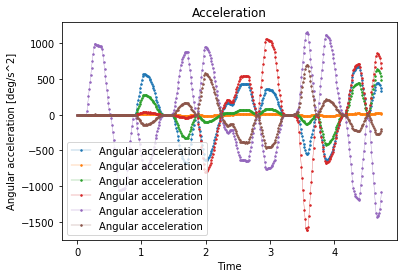

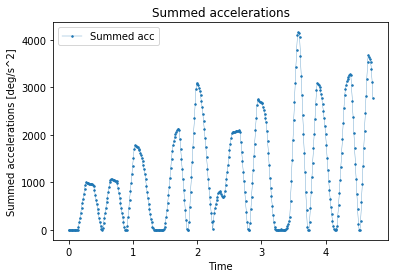

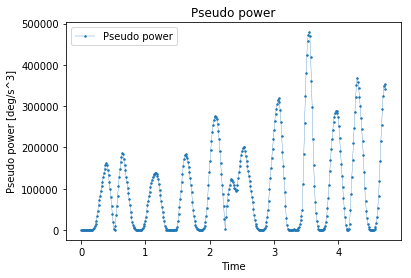

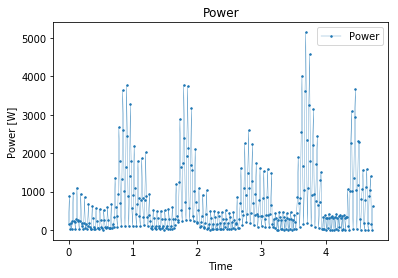

In [60]:
fig1, ax1 = plt.subplots()
ax1.plot(power_time_downsampled[0:400], traj_data[0:400],  label='Angles',  marker='o',linewidth=0.3, markersize=1.5)
ax1.legend();
ax1.set_ylabel('Angles [deg]')
ax1.set_xlabel('Time')
ax1.set_title('Angles');

fig2, ax2 = plt.subplots()
ax2.plot(power_time_downsampled[0:400], vel[0:400],  label='Angular velocity',  marker='o',linewidth=0.3, markersize=1.5)
ax2.legend();
ax2.set_ylabel('Angular velocity [deg/s]')
ax2.set_xlabel('Time')
ax2.set_title('Velocity');

fig3, ax3 = plt.subplots()
ax3.plot(power_time_downsampled[0:400], acc[0:400],  label='Angular acceleration',  marker='o',linewidth=0.3, markersize=1.5)
ax3.legend();
ax3.set_ylabel('Angular acceleration [deg/s^2]')
ax3.set_xlabel('Time')
ax3.set_title('Acceleration');

fig4, ax4 = plt.subplots()
ax4.plot(power_time_downsampled[0:400], np.sum(np.abs(acc[0:400]), axis=1),  label='Summed acc',  marker='o',linewidth=0.3, markersize=1.5)
ax4.legend();
ax4.set_ylabel('Summed accelerations [deg/s^2]')
ax4.set_xlabel('Time')
ax4.set_title('Summed accelerations');

fig5, ax5 = plt.subplots()
ax5.plot(power_time_downsampled[0:400], psi[0:400],  label='Pseudo power',  marker='o',linewidth=0.3, markersize=1.5)
ax5.legend();
ax5.set_ylabel('Pseudo power [deg/s^3]')
ax5.set_xlabel('Time')
ax5.set_title('Pseudo power');

fig6, ax6 = plt.subplots()
ax6.plot(power_time_downsampled[0:400], power_data_synced[0:400],  label='Power',  marker='o',linewidth=0.3, markersize=1.5)
ax6.legend();
ax6.set_ylabel('Power [W]')
ax6.set_xlabel('Time')
ax6.set_title('Power');


In [ ]:
#TODO: Create the augmented input vector

## Low pass filtering

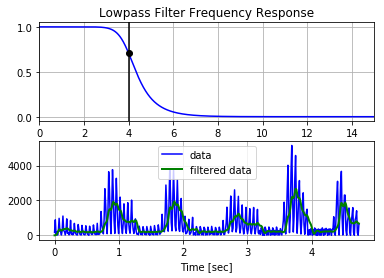

In [76]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 4  # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
b, a = butter_lowpass(cutoff, fs, order)

w, h = freqz(b, a, worN=8000)
plt.subplot(2, 1, 1)
plt.plot(0.5*fs*w/np.pi, np.abs(h), 'b')
plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
plt.axvline(cutoff, color='k')
plt.xlim(0, 0.5*fs)
plt.title("Lowpass Filter Frequency Response")
plt.xlabel('Frequency [Hz]')
plt.grid()

# Filter the data, and plot both the original and filtered signals.
y = butter_lowpass_filter(power_data_synced[0:400], cutoff, fs, order)

plt.subplot(2, 1, 2)
plt.plot(power_time_downsampled[0:400], power_data_synced[0:400], 'b-', label='data')
plt.plot(power_time_downsampled[0:400], y, 'g-', linewidth=2, label='filtered data')
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()